In [ ]:
!pip install transformers pandas scikit-learn torch tqdm huggingface_hub matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import HfApi, Repository, login
import json

In [ ]:
login()

In [ ]:
!pip install openpyxl

In [ ]:
# Load and preprocess dataset
df = pd.read_excel("dataset.xlsx")  # Replace with the path to your dataset

In [ ]:
df["created_at"] = pd.to_datetime(df["created_at"])
if df["created_at"].dt.tz is None:
    df["created_at"] = df["created_at"].dt.tz_localize("UTC")
df["created_at"] = df["created_at"].dt.tz_convert(None)

df["min_date"] = df.groupby("user_id_str")["created_at"].transform("min")
df["max_date"] = df.groupby("user_id_str")["created_at"].transform("max")
df["days_active"] = (df["max_date"] - df["min_date"]).dt.days + 1
df["tweet_count"] = df.groupby("user_id_str")["user_id_str"].transform("count")
df["tweet_per_day"] = df["tweet_count"] / df["days_active"]
df.drop(["min_date", "max_date", "days_active", "tweet_count"], axis=1, inplace=True)


<ipython-input-6-c11d22f594ea>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"])


In [ ]:

# Columns used in the model
text_col = "full_text"
label_col = "label"
numerical_cols = ["tweet_per_day", "favorite_count", "retweet_count", "reply_count", "quote_count"]

# Drop rows with missing values in important columns
df.dropna(subset=[text_col, label_col] + numerical_cols, inplace=True)

In [ ]:
# Map labels to numbers
label_map = {'human': 0, 'bot': 1}
df[label_col] = df[label_col].map(label_map)

# Extract text and labels
X_text = df[text_col].astype(str).tolist()
y = df[label_col].astype(int).values

# Normalize numerical features
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df[numerical_cols])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = AutoModel.from_pretrained("bert-base-multilingual-cased")
encoded = tokenizer(
    X_text,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
class BotDetectionDataset(Dataset):
    def __init__(self, input_ids, attention_mask, numerical_features, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.numerical_features = torch.tensor(numerical_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'numerical_features': self.numerical_features[idx],
            'labels': self.labels[idx]
        }

# Split data
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

train_dataset = BotDetectionDataset(
    input_ids=encoded['input_ids'][train_idx],
    attention_mask=encoded['attention_mask'][train_idx],
    numerical_features=X_numerical[train_idx],
    labels=y[train_idx]
)
test_dataset = BotDetectionDataset(
    input_ids=encoded['input_ids'][test_idx],
    attention_mask=encoded['attention_mask'][test_idx],
    numerical_features=X_numerical[test_idx],
    labels=y[test_idx]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
class mBERTBotClassifier(nn.Module):
    def __init__(self, bert_model, num_numerical_features):
        super(mBERTBotClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.fc_text = nn.Linear(self.bert.config.hidden_size, 128)
        self.fc_numeric = nn.Linear(num_numerical_features, 32)
        self.classifier = nn.Linear(128 + 32, 1)

    def forward(self, input_ids, attention_mask, numerical_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.last_hidden_state[:, 0, :]  # [CLS]
        text_feat = self.dropout(self.fc_text(pooled_output))
        numeric_feat = self.fc_numeric(numerical_features)
        combined = torch.cat((text_feat, numeric_feat), dim=1)
        logits = self.classifier(combined)
        return torch.sigmoid(logits).squeeze()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mBERTBotClassifier(bert_model=bert_model, num_numerical_features=len(numerical_cols)).to(device)

criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)


# Training loop
def train(model, dataloader):
    model.train()
    total_loss = 0
    all_labels = []
    all_preds = []

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        num_feat = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, num_feat)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (outputs > 0.5).long()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    accuracy = (np.array(all_labels) == np.array(all_preds)).mean()
    return total_loss / len(dataloader), accuracy, precision, recall, f1


# Training
epoch_metrics = []
for epoch in range(10):
    loss, accuracy, precision, recall, f1 = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    epoch_metrics.append({
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

Training: 100%|██████████| 1000/1000 [01:26<00:00, 11.55it/s]


Epoch 1, Loss: 0.2911, Accuracy: 0.8733, Precision: 0.8611, Recall: 0.8916, F1: 0.8761


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.68it/s]


Epoch 2, Loss: 0.1596, Accuracy: 0.9416, Precision: 0.9445, Recall: 0.9388, F1: 0.9417


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Epoch 3, Loss: 0.0863, Accuracy: 0.9704, Precision: 0.9709, Recall: 0.9703, F1: 0.9706


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.66it/s]


Epoch 4, Loss: 0.0587, Accuracy: 0.9796, Precision: 0.9801, Recall: 0.9792, F1: 0.9797


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.66it/s]


Epoch 5, Loss: 0.0377, Accuracy: 0.9884, Precision: 0.9894, Recall: 0.9876, F1: 0.9885


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Epoch 6, Loss: 0.0324, Accuracy: 0.9904, Precision: 0.9888, Recall: 0.9922, F1: 0.9905


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Epoch 7, Loss: 0.0219, Accuracy: 0.9937, Precision: 0.9944, Recall: 0.9930, F1: 0.9937


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.70it/s]


Epoch 8, Loss: 0.0223, Accuracy: 0.9936, Precision: 0.9938, Recall: 0.9934, F1: 0.9936


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Epoch 9, Loss: 0.0185, Accuracy: 0.9936, Precision: 0.9937, Recall: 0.9937, F1: 0.9937


Training: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]

Epoch 10, Loss: 0.0150, Accuracy: 0.9957, Precision: 0.9958, Recall: 0.9958, F1: 0.9958


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            num_feat = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, num_feat)
            loss = criterion(outputs, labels)  # <- Hitung loss

            total_loss += loss.item()

            preds = (outputs > 0.5).long()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(dataloader)  # <- Rata-rata loss
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    accuracy = (np.array(all_labels) == np.array(all_preds)).mean()

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds


In [ ]:
val_loss, val_acc, val_prec, val_rec, val_f1, true_labels, pred_labels = evaluate(model, test_loader)

# Tampilkan hasil
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, zero_division=0))
print(f"[Validation] Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")


Evaluating: 100%|██████████| 250/250 [00:06<00:00, 38.06it/s]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2008
         1.0       0.93      0.94      0.94      1992

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000

[Validation] Loss: 0.3580, Acc: 0.9370, Precision: 0.9333, Recall: 0.9408, F1: 0.9370


In [ ]:
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        num_feat = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask, num_feat)
        probs = torch.sigmoid(outputs)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend((outputs > 0.5).long().cpu().numpy())
        y_probs.extend(probs.cpu().numpy())


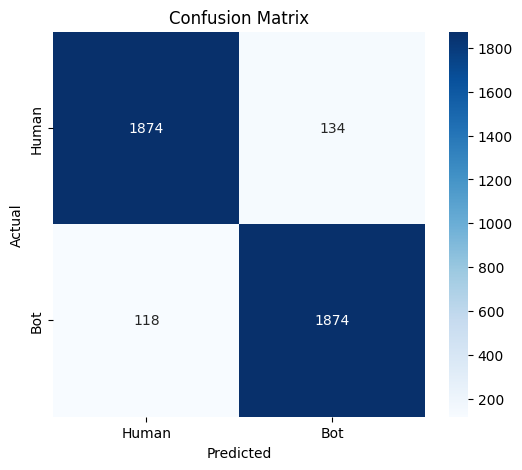

In [ ]:
# Metrics: confusion matrix, classification report, and ROC AUC
conf_matrix = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("./bot-detection-mbert/confusion_matrix.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()

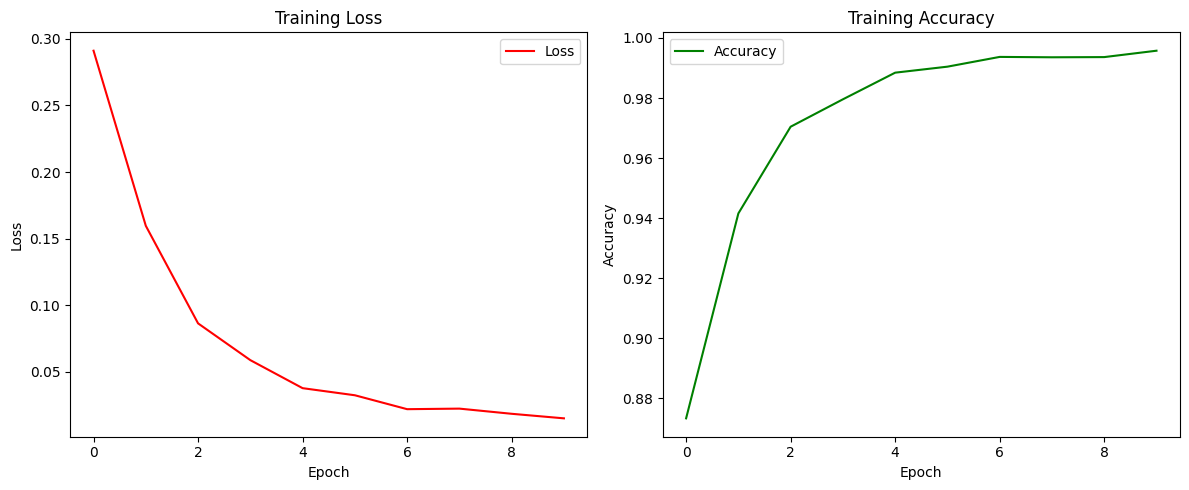

In [ ]:
import matplotlib.pyplot as plt

# Kalau belum ada, ambil dari epoch_metrics
losses = [m["loss"] for m in epoch_metrics]
accuracies = [m["accuracy"] for m in epoch_metrics]

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("./bot-detection-mbert/training_phase.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()

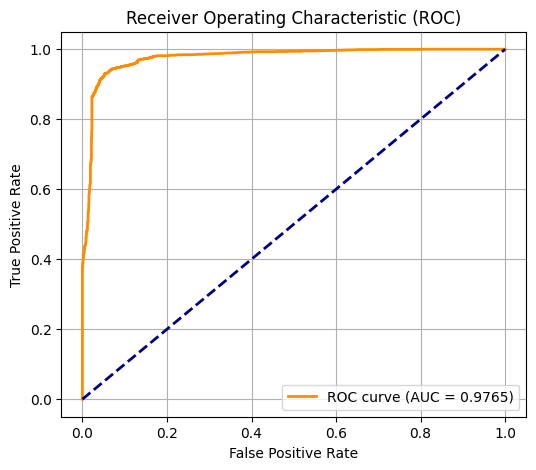

In [ ]:
# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("./bot-detection-mbert/roc.png")  # Simpan gambar dulu
plt.show()  # Baru tampilkan

plt.close()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, pred_labels, zero_division=0)

readme_file = "README.md"
with open(readme_file, "w") as f:
    f.write("# IndoBERT-GRU for Bot Detection on Platform X\n\n")
    f.write("This model uses **MBERT** to classify Twitter/X accounts as bots or humans based on their textual content and numeric features.\n\n")

    f.write("## Model Architecture\n")
    f.write("- Base Model: `bert-base-multilingual-cased`\n")
    f.write("- Classifier: 2-layer feedforward with ReLU + Sigmoid\n\n")

    f.write("## Dataset\n")
    f.write("The dataset includes Indonesian tweets with labels (`0` for human, `1` for bot), along with additional numeric features such as `favorite_count`, `retweet_count`, `reply_count`, and `quote_count`.\n\n")

    f.write("## Training Details\n")
    f.write(f"- Loss Function: Binary Cross Entropy (BCELoss)\n")
    f.write(f"- Optimizer: AdamW (lr = 2e-5)\n")
    f.write(f"- Epochs: {len(epoch_metrics)}\n")
    f.write(f"- Max Token Length: 128\n")
    f.write(f"- Batch Size: 16\n\n")

    f.write("### Training Log\n")
    f.write("| Epoch | Train Loss | Val Accuracy | Precision | Recall | F1-score |\n")
    f.write("|-------|------------|--------------|-----------|--------|----------|\n")
    for i, m in enumerate(epoch_metrics):
        f.write(f"| {i+1} | {m['loss']:.4f} | {m['accuracy']:.4f} | {m['precision']:.4f} | {m['recall']:.4f} | {m['f1']:.4f} |\n")

    f.write("\n## Evaluation Results\n")
    f.write(f"**Final Validation Accuracy**: {val_acc:.4f}\n\n")
    f.write(f"**Final Precision**: {val_prec:.4f}\n")
    f.write(f"**Final Recall**: {val_rec:.4f}\n")
    f.write(f"**Final F1-score**: {val_f1:.4f}\n\n")
    f.write("### Confusion Matrix\n")
    f.write("![Confusion Matrix](./confusion_matrix.png)\n\n")
    f.write("### Training Phase\n")
    f.write("![Training Phase](./training_phase.png)\n\n")

    f.write("### Classification Report\n")
    f.write("```\n")
    f.write(report)
    f.write("\n```\n")


In [ ]:
import torch
import os
import json
from transformers import AutoTokenizer
from huggingface_hub import HfApi, create_repo

# Function to save model and tokenizer
def save_model_to_huggingface(model, tokenizer, model_name):
    # Define model directory
    model_dir = f'./{model_name}'
    os.makedirs(model_dir, exist_ok=True)

    # Save model state_dict
    torch.save(model.state_dict(), os.path.join(model_dir, 'pytorch_model.bin'))

    # Save tokenizer
    tokenizer.save_pretrained(model_dir)

    # Save the model config (optional but helpful for reloading)
    model_config = {
        "hidden_dim": 128,  # or any other parameters you need to store
        "num_numerical_features": len(numerical_cols),
    }
    with open(os.path.join(model_dir, 'config.json'), 'w') as f:
        json.dump(model_config, f)

    return model_dir

# Define your model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = AutoModel.from_pretrained("bert-base-multilingual-cased")
model_name = "bot-detection-mbert"   # <--- Nama repository HuggingFace-mu (string)

# Assuming you already have a trained model 'model'
model_dir = save_model_to_huggingface(model, tokenizer, model_name)


In [ ]:
from huggingface_hub import upload_file

repo_id = "yazidsupriadi/bot-detection-mbert"  # Ganti dengan repo kamu

# Upload file ke Hugging Face
upload_file(path_or_fileobj=readme_file, path_in_repo="README.md", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./bot-detection-mbert/confusion_matrix.png", path_in_repo="confusion_matrix.png", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./bot-detection-mbert/training_phase.png", path_in_repo="training_phase.png", repo_id=repo_id, repo_type="model")
upload_file(path_or_fileobj="./bot-detection-mbert/roc.png", path_in_repo="roc.png", repo_id=repo_id, repo_type="model")
print("✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9635: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


✅ README.md dan confusion matrix berhasil diupload ke model card Hugging Face.


In [ ]:
from huggingface_hub import HfApi, upload_folder
username = "yazidsupriadi"
repo_name = "bot-detection-mbert"
full_repo_id = f"{username}/{repo_name}"
model_dir = "./bot-detection-mbert"  # <-- ini harus sesuai folder yang kamu buat saat save model!

upload_folder(
    repo_id=full_repo_id,
    folder_path=model_dir,
    repo_type="model"
)

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yazidsupriadi/bot-detection-mbert/commit/925aa05dd921b78a073573629d8f0af5ce8ae4a4', commit_message='Upload folder using huggingface_hub', commit_description='', oid='925aa05dd921b78a073573629d8f0af5ce8ae4a4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yazidsupriadi/bot-detection-mbert', endpoint='https://huggingface.co', repo_type='model', repo_id='yazidsupriadi/bot-detection-mbert'), pr_revision=None, pr_num=None)